# Level 2 Binning
## Standard imports

First, setup some standard modules and matplotlib.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

Load the main `sciapy` module.

In [2]:
import sciapy
from sciapy.level2.binning import bin_lat_timeavg

In [3]:
# Increase figure sizes and fix mathtext
plt.rcParams["figure.dpi"] = 120
plt.rcParams["mathtext.default"] = "regular"

In [4]:
# Reduce chattiness of our code
from logging import getLogger
getLogger().setLevel("WARN")

## Raw data

We define helper functions to simplify accessing local or remote data.


In [55]:
import requests
import netCDF4

def load_data_store(store, variables=None, **kwargs):
    with xr.open_dataset(store, **kwargs) as data_ds:
        if variables is not None:
            data_ds = data_ds[variables]
        data_ds.load()
        return data_ds

def load_data_url(url, variables=None, **kwargs):
    with requests.get(url, stream=True) as response:
        nc4_ds = netCDF4.Dataset("data", memory=response.content)
        store = xr.backends.NetCDF4DataStore(nc4_ds)
        return load_data_store(store, variables, **kwargs)

In [6]:
data_ds = load_data_store(
    "SCIAMACHY_NO_NOM_orbits_20120101-20120104_v6.2.1.nc",
    decode_times=False,
    chunks={"latitude": 24, "altitude": 26},
)

We load some data, saved on google drive.
Those are small versions of the full [SCIAMACHY NO data set](https://zenodo.org/record/804371).

In [56]:
#url = "https://drive.google.com/uc?id=1oVs1Ue8OVZpwSFFYFy5JBI3PR5E6dONI"  # 2012-01-01 - 2012-01-03
url = "https://drive.google.com/uc?id=1GZM-4orzEXnRlGMA-n9wo-o5Zv56VB49"  # 2012-01-01 - 2012-01-04

data_ds = load_data_url(
    url,
    decode_times=False,
    chunks={"latitude": 24, "altitude": 26},
)

Binning and averaging is easier on the raw (float) values.
In the case that the data set contains other time variables
except a `time` dimension and coordinate, you can skip
the conversion of time variables using `decode_times=False`.

But then, you have to fix the time coordinate manually:

In [57]:
data_ds["time"] = xr.conventions.decode_cf_variable("time", data_ds.time)

The data set contains the post-processed NO data.
Bascially any data will do as long as it has `time`, `latitude`, and `longitude` dimensions.
You can use a third variable to bin the data on,
in this example, we will use geomagnetic latitudes.
Let's have a look at the content:

In [58]:
data_ds

<xarray.Dataset>
Dimensions:        (altitude: 51, latitude: 72, time: 57)
Coordinates:
  * time           (time) datetime64[ns] 2012-01-01T01:00:34.732819392 ... 2012-01-04T22:33:35.837857984
  * altitude       (altitude) float32 60.0 62.0 64.0 66.0 ... 156.0 158.0 160.0
  * latitude       (latitude) float32 88.75 86.25 83.75 ... -83.75 -86.25 -88.75
Data variables:
    orbit          (time) int32 51453 51454 51455 51456 ... 51507 51508 51509
    longitude      (time, latitude) float32 680.671 316.555 ... -10.1435 -374.26
    NO_DENS        (time, latitude, altitude) float64 9.377e+06 ... 3.359e+06
    NO_ERR         (time, latitude, altitude) float64 1.723e+06 ... 2.664e+05
    NO_ETOT        (time, latitude, altitude) float64 1.236e+08 ... 6.79e+07
    NO_RSTD        (time, latitude, altitude) float64 18.38 16.42 ... 7.931
    NO_AKDIAG      (time, latitude, altitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    NO_APRIORI     (time, latitude, altitude) float64 0.0 0.0 ... 2.209e+07
    NO_N

The easiest way to bin the data into geomagnetic locations is to use
the provided pre-calculated geomagnetic latitudes.
Those variables are derived from the latitude/longitude combinations,
so they have the same dimension as `longitude`:

In [59]:
data_ds.gm_lats

<xarray.DataArray 'gm_lats' (time: 57, latitude: 72)>
array([[ 84.331696,  85.02615 ,  87.76751 , ..., -74.830956, -72.70978 ,
        -75.02266 ],
       [ 84.78126 ,  86.64528 ,  85.1038  , ..., -72.68119 , -72.63666 ,
        -75.029884],
       [ 85.00402 ,  87.574165,  82.686935, ..., -71.149734, -73.09879 ,
        -75.2403  ],
       ...,
       [ 82.65202 ,  80.4589  ,  83.06682 , ..., -82.20558 , -76.527885,
        -76.3305  ],
       [ 83.02436 ,  81.3985  ,  85.5422  , ..., -80.9352  , -75.00373 ,
        -75.81156 ],
       [ 83.523766,  82.68859 ,  88.19489 , ..., -78.5798  , -73.75882 ,
        -75.37667 ]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2012-01-01T01:00:34.732819392 ... 2012-01-04T22:33:35.837857984
  * latitude  (latitude) float32 88.75 86.25 83.75 ... -83.75 -86.25 -88.75
Attributes:
    long_name:  geomagnetic_latitude
    model:      IGRF
    units:      degrees_north

To calculate daily means, we use `xarray`'s `resample` interface
and apply the binning function via `.apply()`:

In [60]:
data_binned = data_ds.resample(time="1d").apply(
    bin_lat_timeavg,
    binvar="gm_lats",
    bins=np.r_[-90:91:30],
    area_weighted=False,
)

/home/ben/Work/miniconda3/envs/stats/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


This run produces a data set resampled to daily values and 30° geomagnetic latitude bins.
In addition to the mean values, `bin_lat_timeavg` calculates the standard deviation and
number of averaged data points.
Both values are supplied as `<var>_std` and `<var>_cnt`, where `<var>` stands for the
data variable in question.

In [61]:
data_binned

<xarray.Dataset>
Dimensions:            (altitude: 51, gm_lats_bins: 6, time: 4)
Coordinates:
  * time               (time) datetime64[ns] 2012-01-01 ... 2012-01-04
  * gm_lats_bins       (gm_lats_bins) float64 -75.0 -45.0 -15.0 15.0 45.0 75.0
  * altitude           (altitude) float32 60.0 62.0 64.0 ... 156.0 158.0 160.0
Data variables:
    orbit              (time, gm_lats_bins) float64 5.146e+04 ... 5.15e+04
    longitude          (time, gm_lats_bins) float32 60.51928 ... 295.44537
    NO_DENS            (time, gm_lats_bins, altitude) float64 -2.082e+07 ... 7.386e+06
    NO_ERR             (time, gm_lats_bins, altitude) float64 1.334e+07 ... 1.509e+06
    NO_ETOT            (time, gm_lats_bins, altitude) float64 9.214e+07 ... 8.038e+07
    NO_RSTD            (time, gm_lats_bins, altitude) float64 163.0 ... 32.98
    NO_AKDIAG          (time, gm_lats_bins, altitude) float64 0.006177 ... 0.0007348
    NO_APRIORI         (time, gm_lats_bins, altitude) float64 0.0 ... 1.424e+07
    NO_NO

The data are now binned into daily 30° latitude bins,
but we probably want the latitudes still be named "latitude".

In [62]:
data_binned = data_binned.rename({"gm_lats_bins": "latitude"})

## External binning

There are various packages around for converting geographic locations
to geomagnetic locations (or whatever geo-coordinate system you like).

Two of the main packages usually used are
[aacgmv2](https://aacgmv2.readthedocs.io) and
[apexpy](https://apexpy.readthedocs.io)

### aacgmv2

In [63]:
import aacgmv2

For using the `sciapy.level2.binning` method,
you need to put the coordinates you want to bin tghe data on
into data variables first.
You can set this variable for example by defining helper function like this
(the `idx` parameter can be used for switching to longitudes by setting it to `1`):

In [64]:
def conv_gm_lat(da, idx=0, alt=110.):
    return [aacgmv2.convert(
                da.latitude.data,
                d,
                alt,
                date=d.time.data.astype("M8[s]").astype("O"),
            )[idx]
            for d in da
           ]

Then apply the helper function to the longitudes through via `.pipe()`.
If you supply a new data variable directly as a tuple has the advantage that `xarray`
can work its magic and assigns the dimensions and coordinates automatically:

In [65]:
data_ds["AACGMv2_lats"] = (
    ["time", "latitude"],
    data_ds.longitude.pipe(conv_gm_lat, idx=0, alt=data_ds.altitude.mean()))

/home/ben/Work/miniconda3/envs/stats/lib/python3.6/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: AACGM_v2_Convert returned error code -1
  outputs = ufunc(*inputs)


Alternatively, you can supply the latitude list directly via
an appropriate list comprehension:

In [66]:
data_ds["AACGMv2_lats2"] = (
    ["time", "latitude"],
    [aacgmv2.convert(
         data_ds.latitude.data,
         long.data,
         data_ds.altitude.mean().data,
         date=date.data.astype("M8[s]").astype("O"),
     )[0]
     for date, long in zip(data_ds.time, data_ds.longitude)])

Whatever way you chose to prepare the data variable to bin the data on,
you can now use it in the same way as `gm_lats` before:

In [67]:
data_binned2 = data_ds.resample(time="1d").apply(
    bin_lat_timeavg,
    binvar="AACGMv2_lats",
    bins=np.r_[-90:91:30],
    area_weighted=False,
)

In [68]:
data_binned2

<xarray.Dataset>
Dimensions:            (AACGMv2_lats_bins: 6, altitude: 51, time: 4)
Coordinates:
  * time               (time) datetime64[ns] 2012-01-01 ... 2012-01-04
  * AACGMv2_lats_bins  (AACGMv2_lats_bins) float64 -75.0 -45.0 ... 45.0 75.0
  * altitude           (altitude) float32 60.0 62.0 64.0 ... 156.0 158.0 160.0
Data variables:
    orbit              (time, AACGMv2_lats_bins) float64 5.146e+04 ... 5.15e+04
    longitude          (time, AACGMv2_lats_bins) float32 56.82753 ... 290.32748
    NO_DENS            (time, AACGMv2_lats_bins, altitude) float64 -2.081e+07 ... 7.647e+06
    NO_ERR             (time, AACGMv2_lats_bins, altitude) float64 1.334e+07 ... 1.611e+06
    NO_ETOT            (time, AACGMv2_lats_bins, altitude) float64 9.214e+07 ... 8.028e+07
    NO_RSTD            (time, AACGMv2_lats_bins, altitude) float64 146.0 ... 35.93
    NO_AKDIAG          (time, AACGMv2_lats_bins, altitude) float64 0.006205 ... 0.0009047
    NO_APRIORI         (time, AACGMv2_lats_bins, al

In [69]:
data_binned2 = data_binned2.rename({"AACGMv2_lats_bins": "latitude"})

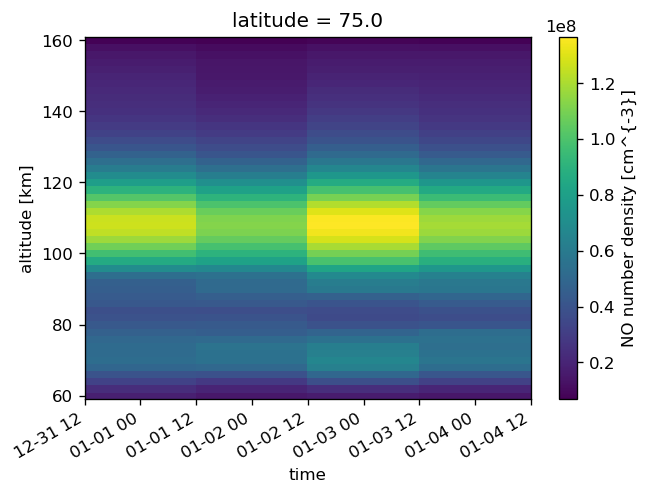

In [70]:
data_binned2.sel(latitude=75).NO_DENS.plot(x="time")

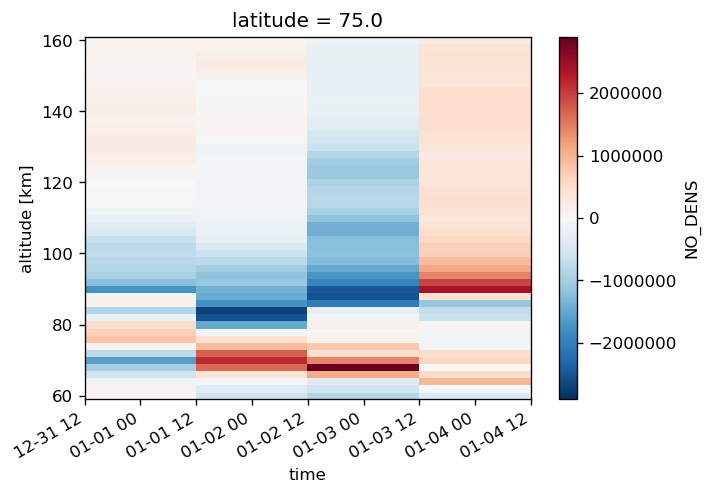

In [71]:
(data_binned2.sel(latitude=75).NO_DENS - data_binned.sel(latitude=75).NO_DENS).plot(x="time")

### apexpy

In [72]:
import apexpy

For the sake of brewity, we skip the definition of a helper function
and construct the bin variables directly.
`apexpy` provides two main variants, "quasi-dipole" and "apex" coordinates,
see also [1] and the other [references](https://apexpy.readthedocs.io/en/latest/authors.html)
on the [apexpy documentation page](https://apexpy.readthedocs.io)

[1] Emmert, J. T., A. D. Richmond, and D. P. Drob (2010), A computationally compact representation of Magnetic-Apex and Quasi-Dipole coordinates with smooth base vectors, J. Geophys. Res., 115(A8), A08322, [doi:10.1029/2010JA015326](https://doi.org/10.1029/2010JA015326).

In [73]:
data_ds["qd_lats"] = (
    ["time", "latitude"],
    [apexpy.Apex(date=date.data.astype("M8[s]").astype("O"))
         .convert(
             data_ds.latitude.values,
              long.values,
              "geo",
              "qd",
              height=data_ds.altitude.mean().values,
         )[0]
     for date, long in zip(data_ds.time, data_ds.longitude)])

In [74]:
data_ds["apex_lats"] = (
    ["time", "latitude"],
    [apexpy.Apex(date=date.data.astype("M8[s]").astype("O"))
         .convert(
             data_ds.latitude.values,
              long.values,
              "geo",
              "apex",
              height=data_ds.altitude.mean().values,
         )[0]
     for date, long in zip(data_ds.time, data_ds.longitude)])

In [75]:
data_binnedqd = data_ds.resample(time="1d").apply(
    bin_lat_timeavg,
    binvar="qd_lats",
    bins=np.r_[-90:91:30],
    area_weighted=False,
)

/home/ben/Work/miniconda3/envs/stats/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [76]:
data_binnedqd = data_binnedqd.rename({"qd_lats_bins": "latitude"})

In [77]:
data_binnedapex = data_ds.resample(time="1d").apply(
    bin_lat_timeavg,
    binvar="apex_lats",
    bins=np.r_[-90:91:30],
    area_weighted=False,
)

In [78]:
data_binnedapex = data_binnedapex.rename({"apex_lats_bins": "latitude"})

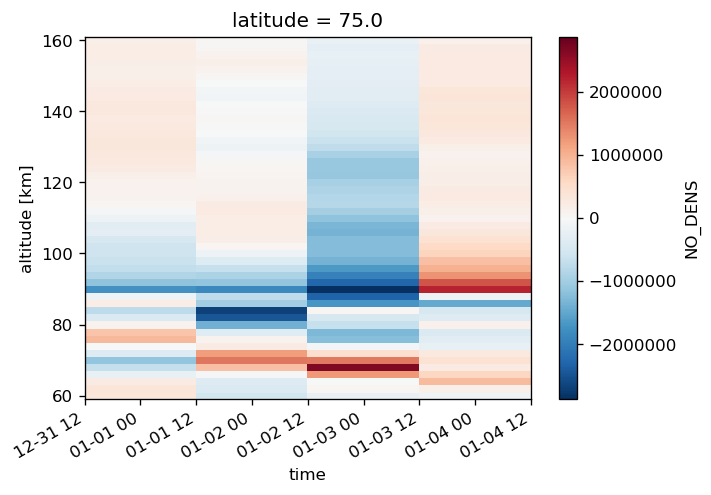

In [79]:
(data_binnedqd.sel(latitude=75).NO_DENS - data_binned.sel(latitude=75).NO_DENS).plot(x="time")

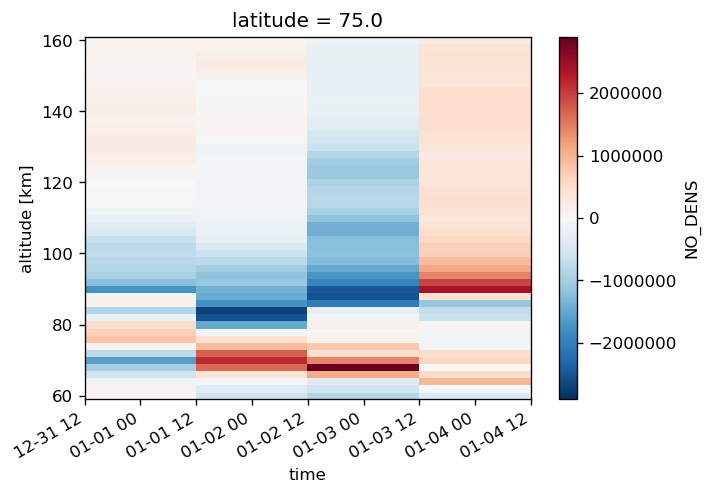

In [80]:
(data_binnedapex.sel(latitude=75).NO_DENS - data_binned.sel(latitude=75).NO_DENS).plot(x="time")

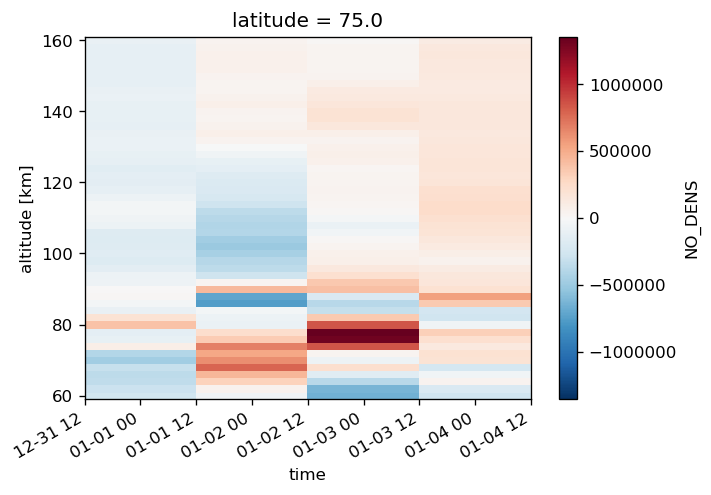

In [81]:
(data_binnedapex.sel(latitude=75) - data_binnedqd.sel(latitude=75)).NO_DENS.plot(x="time")

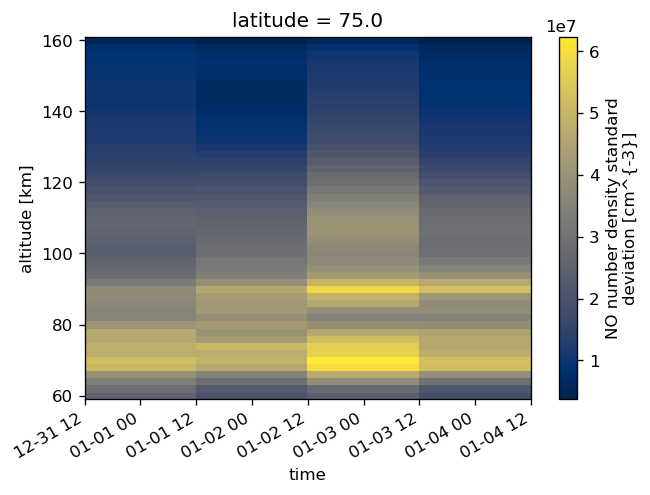

In [82]:
data_binned2.sel(latitude=75).NO_DENS_std.plot(x="time", cmap="cividis")

In [83]:
mean_N = data_binned2.NO_ERR_cnt
mean_var = (mean_N - 1) / mean_N * data_binned2.NO_ERR_std**2 + data_binned2.NO_ERR**2
mean_err = np.sqrt(mean_var)

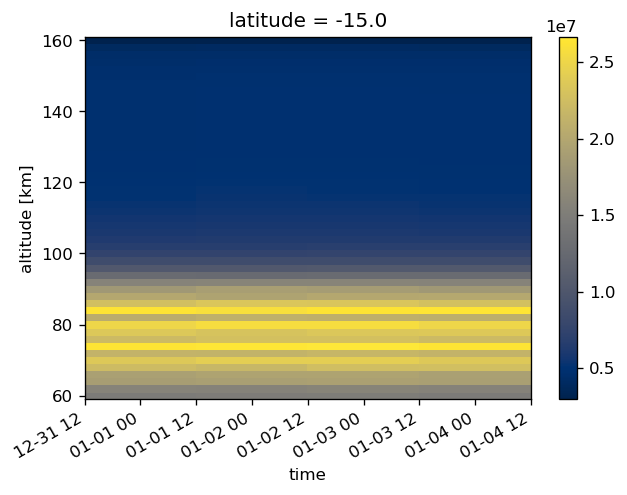

In [84]:
mean_err.sel(latitude=-15).plot(x="time", cmap="cividis")

In [85]:
full_var = data_binned2.NO_DENS_std**2 + mean_var
full_err = np.sqrt(full_var)

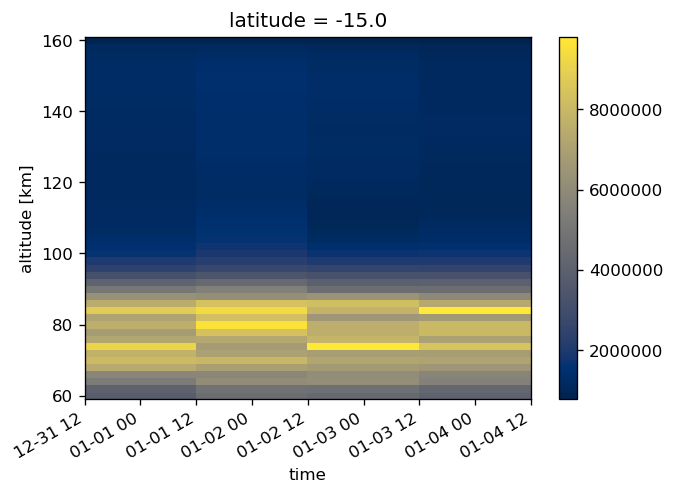

In [86]:
(full_err - data_binned2.NO_DENS_std).sel(latitude=-15).plot(x="time", cmap="cividis")

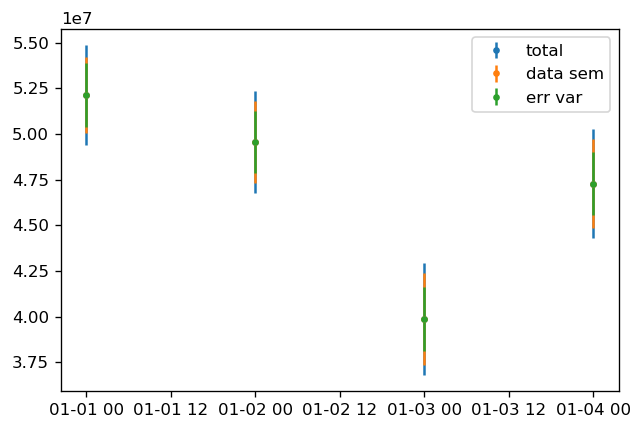

In [87]:
lat, alt = -15, 72
data_bin = data_binned2.sel(latitude=lat, altitude=alt)
plt.errorbar(data_bin.time.data,
             data_bin.NO_DENS.data,
             yerr=full_err.sel(latitude=lat, altitude=alt) / np.sqrt(mean_N.sel(latitude=lat, altitude=alt)),
             fmt='.',
             label="total",
            )
plt.errorbar(data_bin.time.data,
             data_bin.NO_DENS.data,
             yerr=data_bin.NO_DENS_std.data / np.sqrt(mean_N.sel(latitude=lat, altitude=alt)),
             fmt='.',
             label="data sem",
            )
plt.errorbar(data_bin.time.data,
             data_bin.NO_DENS.data,
             yerr=mean_err.sel(latitude=lat, altitude=alt) / np.sqrt(mean_N.sel(latitude=lat, altitude=alt)),
             fmt='.',
             label="err var",
            )
plt.legend();